# Project - Day 3 - Computer Vision and Image Analysis with Deep Learning techniques

## Introduction

During the first two days of the school, you have learned to acquire data and process them, even if your dataset is larger than what your memory can handle.
In this notebook we will focus, instead, on the statistical analysis you can perform on data. 
This is often a crucial step to distill information from the original dataset, and is often sufficiently computing-intensive to make data management techniques discussed in this school critical to the success of the analysis.

## Recap

Already during the part of the exercise discussed on the first day, you downloaded data from `pandora`.

This is a set of simulated data that people tried hard to make as similar as possible to the acquired data, though minor differences might appear.
You should use it to traing your model and to ensure your model is not overfitting. 

You may also try to measure the performance of the model, but remember this is not real data.


In [1]:
%%bash
## Ensure the directory data exists
mkdir -p data

## Download the training dataset from an INFN archive
wget https://pandora.infn.it/public/269d22/dl/training_set.zip -qO data/training_set.zip

## Install the unzip utility 
apt-get -qy install unzip

## Extract the archive
unzip -qn data/training_set.zip 

Reading package lists...
Building dependency tree...
Reading state information...
unzip is already the newest version (6.0-26ubuntu3.1).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.


As in the previous notebooks, you can list all the files obtained from the unzipped archive globbing `data/export/*/*/*/*.png`.

In [2]:
from glob import glob
filenames = glob("data/export/*/*/*/*.png")
print (f"Found {len(filenames)} filenames")

Found 612 filenames


## Preprocessing steps ⚙️⚙️⚙️

The preprocessing steps were discussed during the previous days, here we are just copy-pasting the functions discussed there 📋.

In particular you have here the implementations of:
 * `load_image`, which is `dask.delayed` wrapper around PIL and numpy to load an image as numpy array
 * `load_raw_images`, which loads all the images from a list of file names passed as argument and returns a dask array with stacked images
 * `windowing`, which maps the pixel values from the interval [0, 255] to [0, 1] while clipping the extreme values (below 60 and above 130)
 * `crop_center`, which crops the center of the image where the signal is located, returning a square with side 128 pixels.

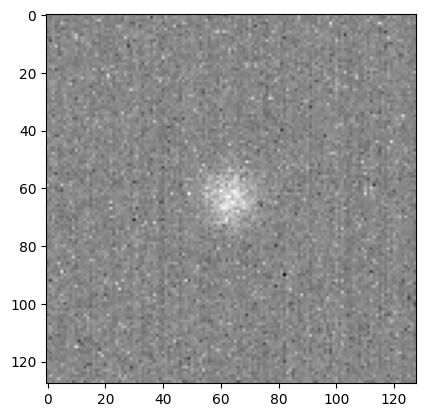

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import dask, dask.array
import tensorflow as tf

## See Day 2
@dask.delayed 
def load_image(filename: str):
    """Wrapper function loading image as a dask.delayed"""
    return np.asarray(Image.open(filename))

## See Day 2
def load_raw_images(filenames):
    """Load the images from the file paths in `filenames` into a delayed dask-array"""
    return dask.array.stack([
        dask.array.from_delayed(load_image(f), shape=(576, 576), dtype=np.uint8) 
        for f in filenames
    ], axis=0)


## Discussed in Day 1, implemented in Day 2
def windowing(dask_image, x_min, x_max):
    """Maps the pixel values from the interval [x_min, x_max] to [0, 1]"""
    return dask.array.clip((dask_image - x_min)/(x_max - x_min), 0., 1.)

## Discussed in Day 1, implemented in Day 2
def crop_center(dask_image, half_win=64):
    """Crop a numpy-represented image around its center, the resulting image will be a square of side 2*half_win"""
    low, high = 576//2 - half_win, 576//2 + half_win
    return dask_image[:,low:high, low:high]

preprocessed = crop_center(windowing(load_raw_images(filenames), 60, 130))
plt.imshow(preprocessed[0].compute(), cmap='gray')
plt.show()

## Retrieving information from the image path 🖍️
As discussed while moving the first steps with the dataset (day 1), we can retrieve information on the energy and on the event type.

In notebook 1, we solved it with plain Python, here it is done (in one line) with regular expressions, which seems nice, but beware of following quote from [Jamie Zawinski](https://blog.codinghorror.com/regular-expressions-now-you-have-two-problems/#:~:text=If%20you've%20ever%20talked,hacker%20who%20I%20admire%20greatly.)  😁😁😁:
 > Some people, when confronted with a problem,
 > think *"I know, I'll use regular expressions."*
 >
 > Now they have two problems.


In [4]:
import re
def energy_keV_from_path(filenames):
    """
    Return a dask array with the energy (in keV) as obtained parsing a sequence of filenames passed 
    as an argument.
    """
    return dask.array.from_array([float(re.findall(r"/([0-9]+)_keV", f)[0]) for f in filenames])

def is_nuclear_from_path(filenames):
    """
    Return an array of boolean, true for nuclear recoil, or false for electron recoils as 
    obtained parsing the list of filenames passed as an argument.
    """
    return dask.array.from_array([float('NR' in re.findall(r"/([NE]R)/", f)) for f in filenames])

## Exercise 1 - Preparation of the training 🏋️ and validation 🕵️ datasets

Because of the functioning of glob, the filenames obtained above are ordered. 
If you split them without shuffling, you end up with a validation set which is not representative of the training set.
On the same line, if you split the training dataset in batches without shuffling, subsequent batches will be very different from each other generating large gradients in the loss function and making the training procedure unstable.

For this reason, you should **shuffle** your list of filenames before doing anything else.

Check the [docs of `numpy.random.permutation`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html) to shuffle your globbed list of file names (as stored in the variable `filenames`).

In [5]:
## Solution
shuffled_filenames = np.random.RandomState(seed=42).permutation(filenames)

### 🔀 Split the list of shuffled dataset 

Pick **50 entries** from the shuffled list of filenames (for example the first 50) and reserve them for validation.

The remaining entries will be used to load your training dataset.

In [6]:
## Solution
n_validation = 50
validation_files = shuffled_filenames[:n_validation]
training_files = shuffled_filenames[n_validation:]

### Apply the preprocessing steps 
Apply the functions `windowing` and `crop_center` to the `training_files` and the `validation_files`, to create the dask-delayed training and validation sets.

Similarly, apply the functions `is_nuclear_from_path` and `energy_keV_from_path` to define the *labels* and the *energy* associated to each filename.

The next code cell should look like
```python
training_set = ...
validation_set = ...

training_label = ...
validation_label = ...

training_energy = ...
validation_energy = ...
```


In [7]:
## Solution
training_set = crop_center(windowing(load_raw_images(training_files), 60, 130))
validation_set = crop_center(windowing(load_raw_images(validation_files), 60, 130))

training_label = is_nuclear_from_path(training_files)
validation_label = is_nuclear_from_path(validation_files) 

training_energy = energy_keV_from_path(training_files)
validation_energy = energy_keV_from_path(validation_files)

## Exercise 2 - Verify your dataset 🤔

Before moving forward, it is a good idea to cross-check and print some statistics of the training sample. 

Here you can find a couple of histograms obtained by the organizers during the preparation of the exercise. 
You can compare your dataset to them to avoid wasting time training on a ill-defined dataset.

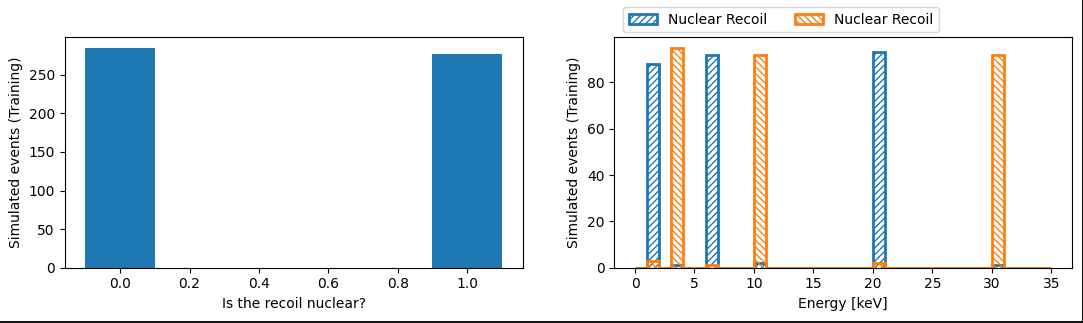

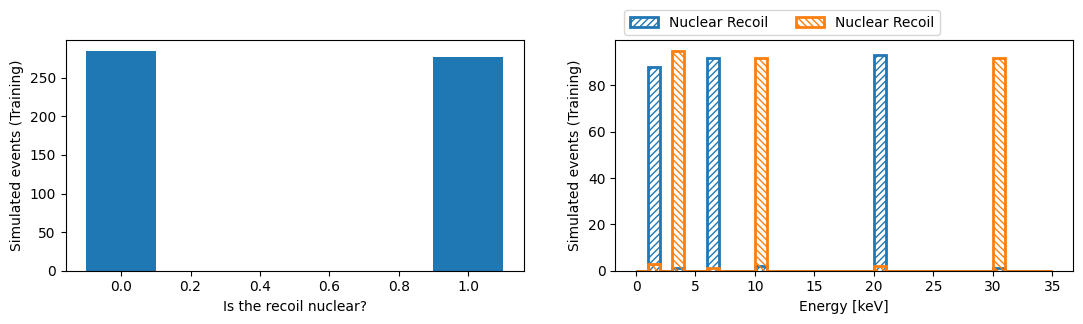

In [8]:
## Solution

plt.figure(figsize=(13,3))
plt.subplot(1, 2, 1)
plt.hist(training_label.compute(), bins=[-0.1,0.1, 0.9, 1.1])
plt.xlabel("Is the recoil nuclear?")
plt.ylabel("Simulated events (Training)")

plt.subplot(1, 2, 2)
plt.hist(training_energy[training_label > 0.5].compute(), bins=np.linspace(0, 35, 36), histtype='step', hatch='/'*5, label="Nuclear Recoil", linewidth=2)
plt.hist(training_energy[training_label < 0.5].compute(), bins=np.linspace(0, 35, 36), histtype='step', hatch='\\'*5, label="Nuclear Recoil", linewidth=2)
plt.xlabel("Energy [keV]")
plt.ylabel("Simulated events (Training)")
plt.legend(ncol=2, loc=(0.02, 1.02))

plt.show()

## Exercise 3 - Define your Convolutional Neural Network 🤖🤖🤖

Define a simple CNN for a classification task.

Remember:
 * The input shape of the preprocessed images is (128, 128)
 * The activation function of the last layer should be a `sigmoid` and the loss should be a Binary Crossentropy
 * It might help to use some regularization of the kernel weights to make the training more stable.
 * Don't make it too complex or it will take forever to train, don't make it too simple or it will perform very poorly and you won't find any dark matter 🙃.

> **Hint.** You may want to use a *learning rate* lower than the default, for example 0.0003

In [9]:
## Solution (to be copied and adapted from MNIST tutorial)

import tensorflow as tf

learning_rate = 3e-4

input = tf.keras.Input(shape=(128,128), name="input")
hidden = tf.keras.layers.Reshape((128, 128, 1), name="reshape")(input)
hidden = tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal')(hidden)
hidden = tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal')(hidden)
hidden = tf.keras.layers.MaxPooling2D(2)(hidden)

hidden = tf.keras.layers.Conv2D(filters=4, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal')(hidden)
hidden = tf.keras.layers.Conv2D(filters=4, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal')(hidden)
hidden = tf.keras.layers.MaxPooling2D(2)(hidden)

hidden = tf.keras.layers.Flatten()(hidden)
output = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')(hidden)

classifier = tf.keras.Model(input, output)
classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate))

display(classifier.summary())

2023-10-06 05:49:59.172891: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-06 05:49:59.177167: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-06 05:49:59.225585: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-06 05:49:59.225618: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-06 05:49:59.225656: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128)]        0         
                                                                 
 reshape (Reshape)           (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 8)       80        
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 8)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 4)         292       
                                                             

2023-10-06 05:50:01.183323: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 145d3b2e882a
2023-10-06 05:50:01.183347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 145d3b2e882a
2023-10-06 05:50:01.183417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-10-06 05:50:01.183484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2


None

## Exercise 4 - Re-chunk your dask arrays to represent batches of the training procedure

The Deep Learning libraries, such as TensorFlow, are designed to benefit from parallelization muliple ways, and expect a large portion of the dataset to be presented to the neural network at once. This is particularly important for "small data entries", such as rows of a table or small MNIST image, for which looping over the instances in Python would waste most of the computing power, but it is still beneficial for images with 16k pixels. 

At the opposite extreme, if the RAM of your system is smaller than the size of your dataset you have no choice but splitting it into batches and process one batch at once.

There are multiple ways to define batches, but since you are now a major expert of dask, we'll do it with dask! 

Use the [`dask.array.rechunk` function](https://docs.dask.org/en/latest/generated/dask.array.rechunk.html) to customize the size of the chunks.

**It is very important that you are consistent between the chunk structure of the input, image data and of the labels indicating whether the recoil is nuclear or electronic.**

We organizers obtained decent results with batches (or chunks) of 10 images, but you are encouraged to explore what happens using larger or smaller batch sizes. 

The following cell might look like
```python

batch_size = 10

X_train = training_set...
X_valid = validation_set...
y_train = training_label...
y_valid = validation_label...

```

In [10]:
## Solution
batch_size = 10

X_train = training_set.rechunk( [batch_size, None, None] )
X_valid = validation_set.rechunk( [-1, None, None] )
y_train = training_label.rechunk(batch_size)
y_valid = validation_label.rechunk(batch_size)

## Exercise 5 - Train for a single epoch 🏋️

An epoch correspond to a training performed on the whole dataset, possibly iterating over multiple batches. 

To iterate on batches and train your neural network (say `classifier`) on each batch, you can use the following structure.

```bash
for X, y in zip(X_train.blocks, y_train.blocks):
  classifier.train_on_batch(X, y)
```

Depending on the complexity of your network, this loop is expected to take 5 to 15 seconds. If it takes longer, there might be something odd happening in your code.

The evolution of the loss through the epoch should not be too different from the following plot.

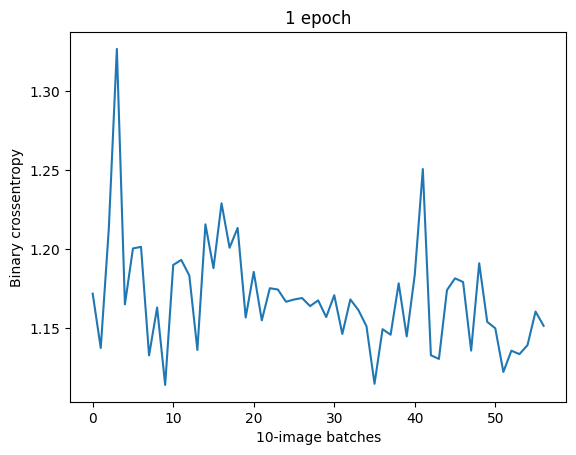

You may want to check:
  * the [docs of `dask.array.blocks`](https://docs.dask.org/en/stable/generated/dask.array.Array.blocks.html#dask-array-array-blocks)
  * the [docs of (keras.Model.train_on_batch)](https://keras.io/api/models/model_training_apis/#trainonbatch-method)

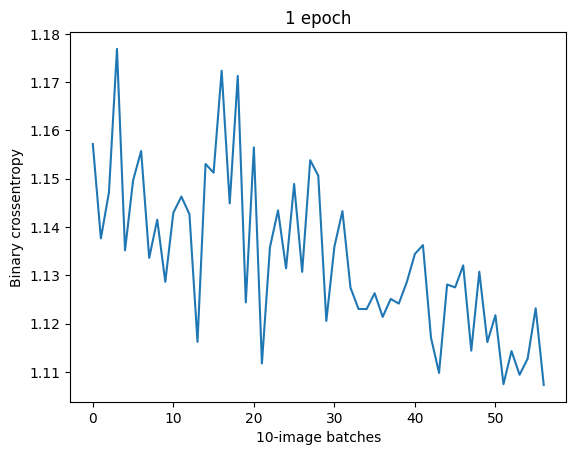

In [11]:
## Solution 
losses = []
for X, y in zip(X_train.blocks, y_train.blocks):
    losses.append(
        classifier.train_on_batch(X, y)
    )
plt.plot(losses)
plt.title("1 epoch")
plt.xlabel("10-image batches")
plt.ylabel("Binary crossentropy")
plt.show()

## Exercise 6 - Train for 50 epochs (🏋️$\times 50$)

You have now the building block to repeat the training multiple times, or for multiple epochs. 
Try for example with 50 epochs. 

For each epoch, you may also want to compute the loss on the validation sample to ensure the model is still able to generalize to your 50 images subtracted to the training dataset.

Code structure may look like:
```python
for epoch in range(50):
  for X, y in zip(X_train.blocks, y_train.blocks):
    classifier.train_on_batch(X_train, y_train)
  classifier.test_on_batch(X_valid, y_valid)
```

You should build a plot comparing the evolution of the two losses (on the training and validation dataset) that might resemble to the following one.

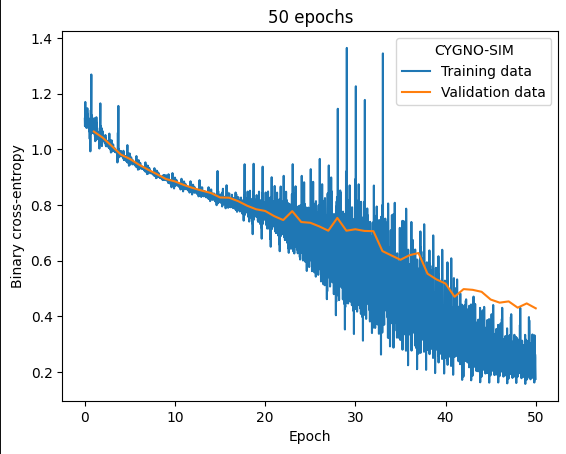

100%|██████████| 50/50 [03:05<00:00,  3.71s/it]


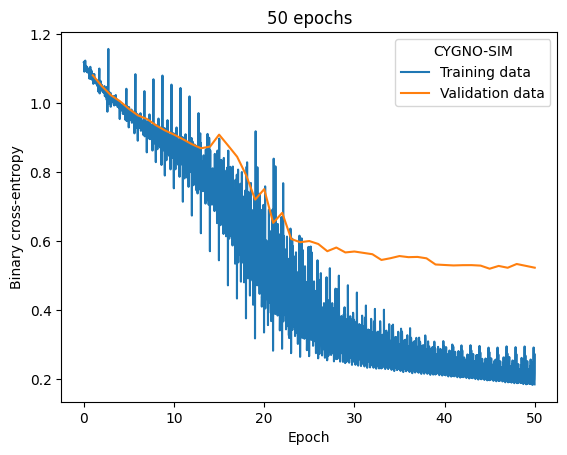

In [12]:
## Solution
losses = []
val_losses = []
from tqdm import trange

n_epochs = 50
n_blocks = y_train.numblocks[0]

for epoch in trange(n_epochs):
    for X, y in zip(X_train.blocks, y_train.blocks):
        losses.append(
            (len(losses)/n_blocks, classifier.train_on_batch(X.compute(), y.compute()))
        )
    val_losses.append(
        (len(losses)/n_blocks, classifier.test_on_batch(X_valid, y_valid))
    )
    
plt.plot(*(np.array(losses).T), label="Training data")
plt.plot(*(np.array(val_losses).T), label="Validation data")
plt.title(f"{n_epochs} epochs")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy")
plt.legend(title="CYGNO-SIM")

plt.show()

## Exercise 7 - How good is your model? 🤑🤑🤑

Evaluate the ability of your model to discriminate nuclear from electron recoils. 
There are several ways to convince ourselves that the model we trained and discussions may take for ever. 

> 🚨**Warning!** 🚨
>
> Performance measurements on the trained model must be done with a statistically
> equivalent dataset independent of the one used for training.
>
> In this particular case, however, we expect the acquired data to be different
> from those used for training, making any performance measurement unsatisfactory
> and unreliable whatever dataset we choose.
>
> Use the validation sample to ensure that the ability of the model to generalize
> not compromised, and then use the whole training+validation dataset to
> evaluate the training procedure in itself and forget about generalization
> capabilities.
>
> We will discuss how to interpret these results in the last part of the exercise.

For the sake of the school, it suggested you limit yourself to a couple of quick checks. For example:

#### Plot the histogram of the DNN response 📊
Plot in a histogram the response of the classifier (a.k.a. the estimated probability of being an 
event due to a nuclear recoil) as obtained on events of the training and validation sample. 

You should be able to reach a rather good separation between the two hypotheses as shown in the 
figure below.

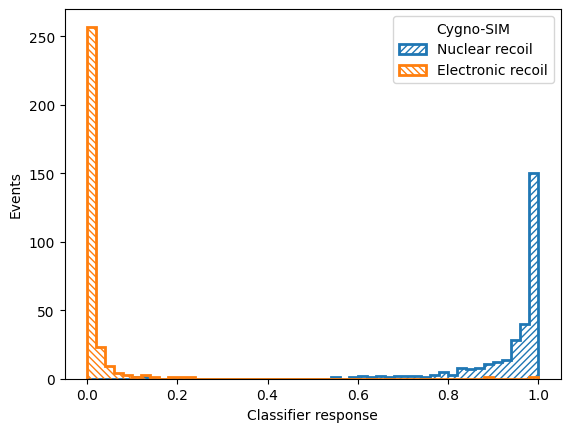


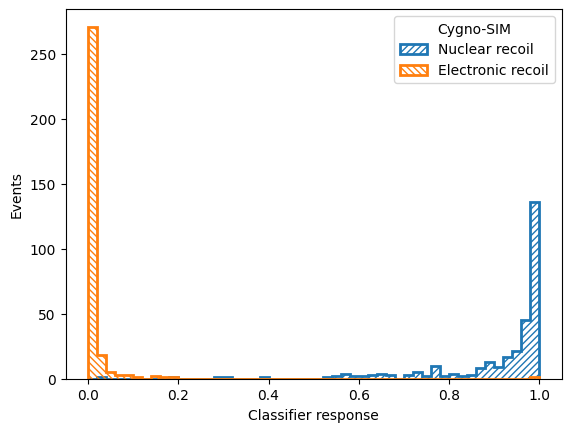

In [13]:
predictions = np.concatenate([classifier(tf.constant(X)) for X in list(X_train.blocks) + list(X_valid.blocks)])
labels = dask.array.concatenate([y_train, y_valid]).compute()
plt.hist(predictions[labels>0.5], bins=np.linspace(0, 1, 51), histtype='step', hatch='/'*5, linewidth=2, label="Nuclear recoil")
plt.hist(predictions[labels<0.5], bins=np.linspace(0, 1, 51), histtype='step', hatch='\\'*5, linewidth=2, label="Electronic recoil")
plt.legend(title="Cygno-SIM")
plt.xlabel("Classifier response")
plt.ylabel("Events")
plt.show()

#### Draw the ROC curve 📉

The [Reciever operating Characteristic curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)  is often used to represent the performance at various regimes of a binary classification algorithm. It is obtained by scanning the threshold on the classifier response and measuring the signal efficiency and background rejection for each scanned threshold.

Putting in a graph these points one gets a curve that may resemble to the following one.

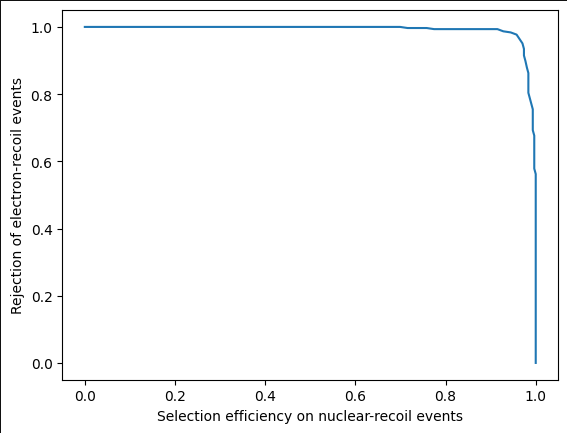

The closer to (1, 1), the better the algorithm performs!

> **Caveats!** 🧐 We are simplifying things a little bit. First of all, we have checked only very roughly that the model is not overfitting too much, so measuring the performance with the training dataset is not rock solid. In addition, we might have tuned the hyperparameters of our model at the point it generalizes to the validation set (and so we are convinced it is not overtrained), but it does not generalize to a third, statistically equivalent, dataset. To do things properly, you should use a third dataset, never used for training only to *measure the performance* of your model. 

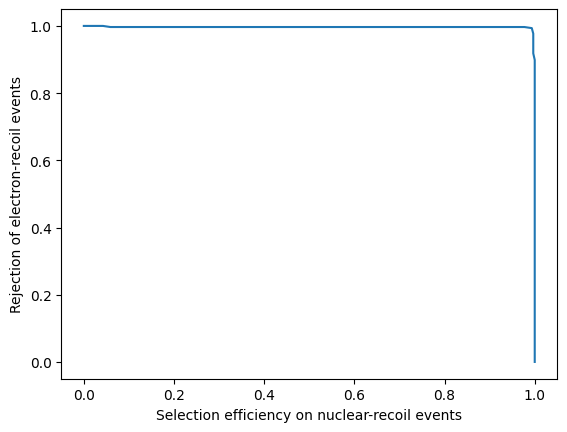

In [14]:
## Solution
thresholds = np.quantile(predictions, np.linspace(0, 1, 101))
nuclear_y = predictions[labels>0.5]
nuclear_efficiency = np.array([ np.count_nonzero( nuclear_y > t) for t in thresholds])/len(nuclear_y)

electronic_y = predictions[labels<0.5]
electronic_rejection = np.array([ np.count_nonzero( electronic_y < t) for t in thresholds])/len(electronic_y)

plt.plot(nuclear_efficiency, electronic_rejection)
plt.xlabel("Selection efficiency on nuclear-recoil events")
plt.ylabel("Rejection of electron-recoil events")
plt.show()

#### Bonus: Visualize the performance in bins of the energy <BIG>🏃‍♀️</BIG>

> **Bonus!** This validation is not required for any successive step of the exercise. You are advised not to waste time on it if you feel in a hurry.

The ability of the model to distinguish the type of recoil may depend on the energy of the collision.
Since the energy used to simulate the event is known, you may want to repeat the visualization exercise above in intervals of the energy, for example 
below 5 keV, between 5 and 15 keV and above 15 keV.

For example, you may obtain something on the line of the following figure
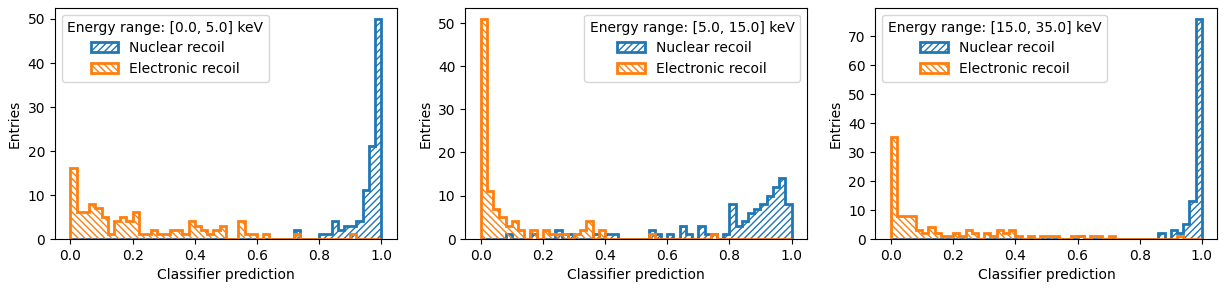

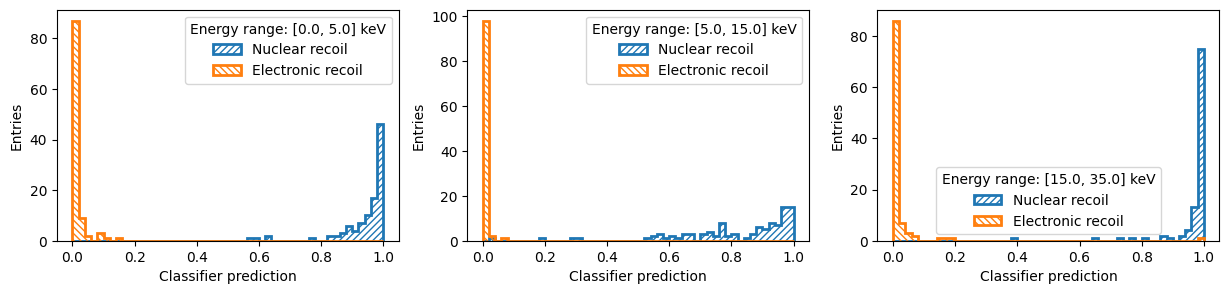

In [15]:
energy_boundaries = 0, 5, 15, 35

predictions = np.concatenate([classifier(tf.constant(X)) for X in list(X_train.blocks) + list(X_valid.blocks)])
labels = dask.array.concatenate([y_train, y_valid]).compute()
energy = dask.array.concatenate([training_energy, validation_energy]).compute()


plt.figure(figsize=(15,3))
for iPlot, (e_min, e_max) in enumerate(zip(energy_boundaries[:-1], energy_boundaries[1:]), 1):
    plt.subplot(1, 3, iPlot)
    plt.hist(predictions[(labels>0.5) & (energy > e_min) & (energy < e_max)], bins=np.linspace(0, 1, 51), histtype='step', hatch='/'*5, linewidth=2, label="Nuclear recoil")
    plt.hist(predictions[(labels<0.5) & (energy > e_min) & (energy < e_max)], bins=np.linspace(0, 1, 51), histtype='step', hatch='\\'*5, linewidth=2, label="Electronic recoil")
    plt.legend(title=f"Energy range: [{e_min:.1f}, {e_max:.1f}] keV")
    plt.xlabel("Classifier prediction")
    plt.ylabel("Entries")
plt.show()


## 🃏 Exercise 8 - Create a Regression model 🔮

>  The 🃏 indicates a bonus track, not strictly needed to complete the project. Feel free to skip and come back later.

If we want to investigate effects related to the energy in acquired data, it might be a good idea to develop some technique to obtain an estimate for the energy of the collision directly from the acquired image. 

Indeed, while for simualated data the information on the collision energy is given, we have no hint on the energy of a real-data collision beyond what we can say from the acquired image itself.

Technically, this is a ***regression task***. You can train a Convolutional Neural Network to predict the value of the energy using the simulation and then employ it in real data as a **reconstruction algorithm**.

Tweak you classifier NN as defined above to face a regression task. Remember:
 * The overall structure, obtained for classification, is most likely ok also for regression
 * The output layer should now return an energy (a sigmoid activation might be less appropriate)
 * Using a Binary Crossentropy, is **definitely** less appropriate. Hoepfully you can pick another loss from the [`keras.losses` module](https://keras.io/api/losses/)

In [16]:
## Solution

import tensorflow as tf

input = tf.keras.Input(shape=(128,128), name="input")
hidden = tf.keras.layers.Reshape((128, 128, 1), name="reshape")(input)
hidden = tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal')(hidden)
hidden = tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal')(hidden)
hidden = tf.keras.layers.MaxPooling2D(2)(hidden)

hidden = tf.keras.layers.Conv2D(filters=4, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal')(hidden)
hidden = tf.keras.layers.Conv2D(filters=4, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal')(hidden)
hidden = tf.keras.layers.MaxPooling2D(2)(hidden)

hidden = tf.keras.layers.Flatten()(hidden)
output = tf.keras.layers.Dense(1, activation='linear', kernel_initializer='he_normal')(hidden)

regressor = tf.keras.Model(input, output)
regressor.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(3e-4))

display(regressor.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128)]        0         
                                                                 
 reshape (Reshape)           (None, 128, 128, 1)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 8)       80        
                                                                 
 conv2d_5 (Conv2D)           (None, 124, 124, 8)       584       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 62, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 4)         292       
                                                           

None

## 🃏 Exercise 9 - Preprocess the energy and re-chunk your dask arrays to represent batches

As you did before for the classification task, you will need to create dask arrays with the right chunk structure for your training and validation sets. 

The target of your algorithm won't be the classification label this time, but rather the energy of the collision 💥! 


As discussed above, training neural networks is much easier if one can count on features of $\mathcal O (1)$. 

Now, the energies in this exercise, expressed in keV, are not too far from $\mathcal O(1)$ so there are chances you can succeed training your network without any preprocessing.

Still, dividing the energy by $30$ keV while rechunking it may make the training faster and it takes literally less than 10 key strokes.


In [17]:
batch_size = 10

X_train = training_set.rechunk( [batch_size, None, None] )
X_valid = validation_set.rechunk( [-1, None, None] )
y_train = (training_energy/30).rechunk(batch_size)
y_valid = (validation_energy/30).rechunk(batch_size)

## 🃏 Exercise 10 - Train the regression model for 50 epochs (🏋️$\times 50$)

The same code snippet developed above for training the classifier on 50 epochs should work here for your regressor, but **don't forget to change your input variables!**

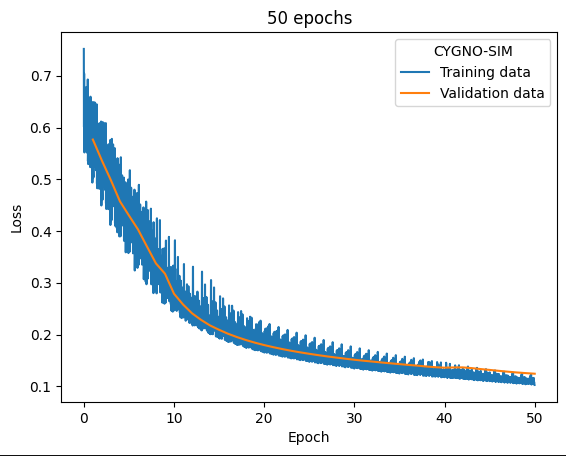


100%|██████████| 50/50 [03:05<00:00,  3.72s/it]


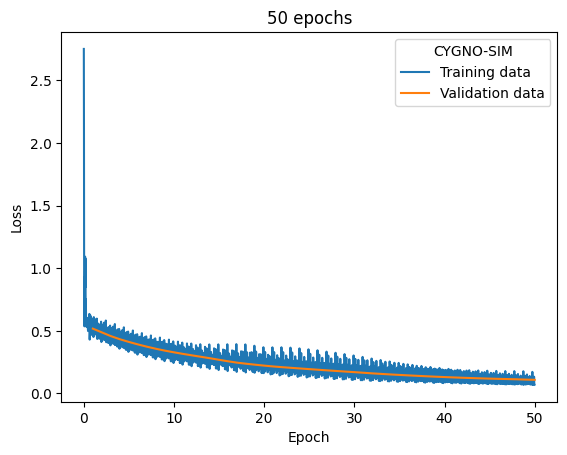

In [18]:
## Solution
losses = []
val_losses = []
from tqdm import trange

n_epochs = 50
n_blocks = y_train.numblocks[0]

for epoch in trange(n_epochs):
    for X, y in zip(X_train.blocks, y_train.blocks):
        losses.append(
            (len(losses)/n_blocks, regressor.train_on_batch(X.compute(), y.compute()))
        )
    val_losses.append(
        (len(losses)/n_blocks, regressor.test_on_batch(X_valid, y_valid))
    )
    
plt.plot(*(np.array(losses).T), label="Training data")
plt.plot(*(np.array(val_losses).T), label="Validation data")
plt.title(f"{n_epochs} epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="CYGNO-SIM")

plt.show()

## 🃏 Exercise 11 - Displaying the performance of your regressor

To validate the classifier neural network we studied the distribution of the response of the neural network for the various classes. 
Here we don't really have classes, but rather a continuos value (the energy) that the neural network should try to guess. 

An option to visualize the quality of the model is to create a scatter plot comparing the predicted value to the *ground-truth*, the energy used during the training. For the ideal regressor, such plot would be a set of points laying on the bisector line, for real regressors the distribution will widen, but will around the bisector line. So the thinner the distribution the better the regressor.

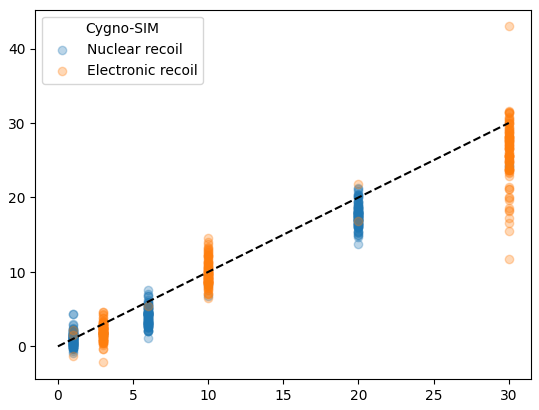

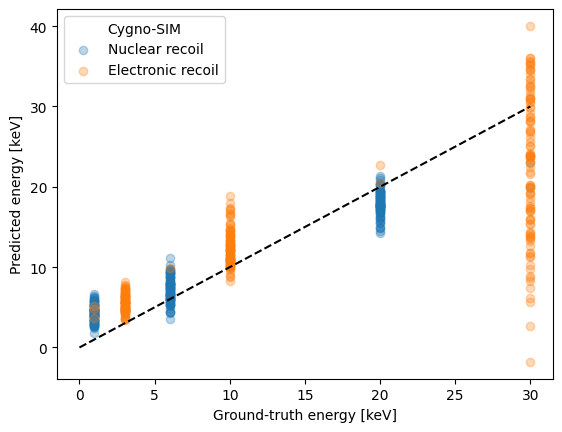

In [20]:
## Solution

## Obtain the predictions from the regressor
predictions = np.concatenate([regressor(tf.constant(X)) for X in list(X_train.blocks) + list(X_valid.blocks)])

## Inverse preprocessing step to retrieve the energy on the original scale
predicted_energy = 30*predictions

## Retrieve the class and the ground-truth for the energy from the original dataset using Dask
energy = dask.array.concatenate([training_energy, validation_energy]).compute()
label = dask.array.concatenate([training_label, validation_label]).compute()

## Create the plot
plt.scatter(energy[label>0.5], predicted_energy[label>0.5], alpha=0.3, label="Nuclear recoil")
plt.scatter(energy[label<0.5], predicted_energy[label<0.5], alpha=0.3, label="Electronic recoil")
plt.plot((0,30), (0, 30), 'k--')
plt.legend(title="Cygno-SIM")
plt.xlabel("Ground-truth energy [keV]")
plt.ylabel("Predicted energy [keV]")
plt.show()

## Exercise 12 - Deploy 🪁

Well done! Now you are ready to use your model to process the events submitted from the DAQ system we have discussed on Day 2.


### Ex. 12.1 - Store the models to files

To push the model in a pipeline, you don't want to have it running in interactive mode (though we all love notebooks) so, as a very first thing, you need to export the model from this notebook and make it available to other applications, possibly without direct access to your filesystem 👉 upload it on Minio.

To store a model you can use [the function `keras.models.Model.save`](https://keras.io/api/saving/model_saving_and_loading/#save-method).

For example,
```python
import tensorflow as tf

my_model = tf.keras.models.Sequential()
# ... define the layers

## Train your model
my_model.fit(...)

## Validate your model
my_model.predict(...)

## And finally, store your model in a local file
my_model.save("my_model.keras")
```




In [23]:
## Store the classifier in a tar file
classifier.save("classifier.keras")

## Store the regressor in a tar file
regressor.save("regressor.keras")

Then upload the model(s) stored locally to Minio by using the s3 protocol and the Minio SDK.

```python
from minio import Minio

minio = Minio("<minio_service>:9000", <minio_user>, <minio_password>, secure=False)

if not minio.bucket_exists(<your_model_bucket):
    minio.make_bucket(<your_model_bucket)

## This line may be repeated multiple times, once per model
minio.fput_object(<your_model_bucket>, <your_model_name>, <path_to_the_locally_saved_model>)

```

In [24]:
## Solution
from minio import Minio
import urllib3

try:
    ## Connect to the minio instance
    minio = Minio("localhost:9000", "sosc_participant", "Perugia2023", secure=False)

    ## Ensure the existence of a bucket dedicated to the models
    if not minio.bucket_exists("cygno-models"):
        minio.make_bucket("cygno-models")

    ## Upload the object to cygno-models
    minio.fput_object("cygno-models", "classifier.keras", "classifier.keras")
    minio.fput_object("cygno-models", "regressor.keras", "regressor.keras")

except urllib3.exceptions.MaxRetryError:
    print ("Minio not found, maybe it is not running")

## ... TO BE CONTINUED ...

The exercise continues in a [separated notebook](./Project-Day3-deploy.ipynb) dedicated to deployment.